# Community detection with a Bayesian stochastic block model (Peixoto, 2017)

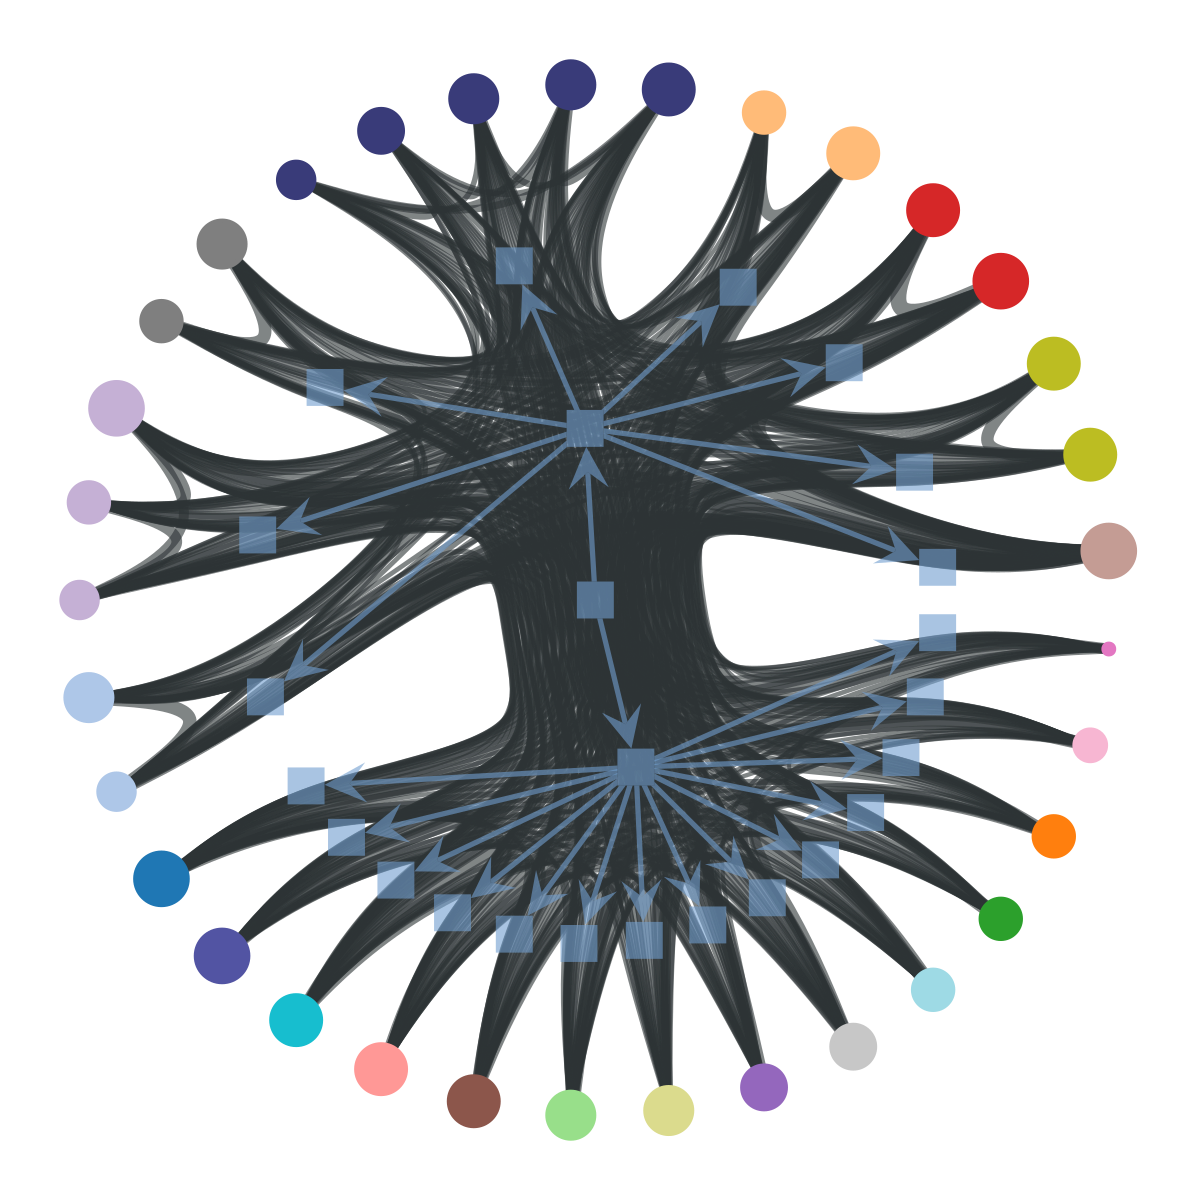

Summary of the hierarchical stochastic block model inferred from the data:
##############################################################################
l = level, N = number of nodes, B = number of blocks
l: 0, N: 33, B: 22
l: 1, N: 22, B: 2
l: 2, N: 2, B: 1
l: 3, N: 1, B: 1
    l 0 :  <BlockState object with 33 blocks (22 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 33 vertices and 487 edges, 1 internal edge property, at 0x79804084da60>, at 0x798036bde210>
    l 1 :  <BlockState object with 24 blocks (2 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 33 vertices and 227 edges, 2 internal vertex properties, 1 internal edge property, at 0x79803f2db5f0>, at 0x79803527dd60>
    l 2 :  <BlockState object with 5 blocks (1 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 24 vertices and 3 edges, 2 internal vertex properties, 1 internal edge property, at 0x798035300050>, at 0x79803527e4b0

In [82]:
import numpy as np
import igraph as ig
import matplotlib
from graph_tool.all import *

n_per_layer = 33

np.set_printoptions(threshold=np.inf)

with open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "r") as f:
    names = f.readline()

names = names.split('" "')
names[0] = names[0][1:]     # strip the first "
names[-1] = names[-1][:-2]  # strip the last \n

names = dict(enumerate(names))

adj_matrix = np.loadtxt(open("outputs/01_dataPreperation/final/CAMaggregated_adj_matrix.csv", "rb"), delimiter=" ", skiprows=1)


# remove self-loops
np.fill_diagonal(adj_matrix, 0)

G = ig.Graph.Adjacency(matrix=adj_matrix, mode="undirected")
G_edge_list = G.get_edgelist()

# ig.plot(G)
# print(G_edge_list)

G_edge_set = set(G_edge_list)
G_edge_list_new = list(G_edge_set)
G_edge_list_new = sorted(G_edge_list_new, key=lambda x: (x[0], x[1]))
# print(G_edge_list_new)

G_gt = Graph(G_edge_list_new, directed=False)
# G_gt_edge_list = list(G_gt.iter_edges())
# G_gt_edge_list = list(map(lambda x: tuple(x), G_gt_edge_list))
# G_gt_edge_list == G_edge_list
# print(G_gt)

G_gt_weights = G_gt.new_edge_property("int")

for edge in G_edge_list_new:
    G_gt_weights[edge] = G_edge_list.count(edge)

# for edge in G_edge_list_new:
#     print(edge, "has weight", G_gt_weights[edge])

G_gt.edge_properties["weight"] = G_gt_weights

graph_tool.seed_rng(12345)

state = minimize_nested_blockmodel_dl(G_gt, state_args=dict(recs=[G_gt.ep.weight], rec_types=["discrete-binomial"]))

for i in range(100):
    ret = state.multiflip_mcmc_sweep(niter=10, beta=np.inf)

state.draw(ecmap=(matplotlib.cm.inferno, .6),
           eorder=G_gt.ep.weight, edge_pen_width=prop_to_size(G_gt.ep.weight, 2, 8, power=1),
           edge_gradient=[])

print("Summary of the hierarchical stochastic block model inferred from the data:")
print("##############################################################################")
print("l = level, N = number of nodes, B = number of blocks")
state.print_summary()

levels = state.get_levels()

for i, s in enumerate(levels):
    print("    l", i, ": ", s)
    if s.get_N() == 1:
        num_levels = i
        break


for j in range(num_levels):
    blocklist = levels[j].get_blocks()
    print("##############################################################################")
    print("LEVEL", j, "with the following blocks with at least 2 members (rest is background):\n")

    for block in set(blocklist):
        indices = [i for i, x in enumerate(blocklist) if x == block]
        if len(indices) > 1:
            print("block", block, "with:", ", ".join(map(lambda x: names[x], indices)))